In [622]:
import requests
import cv2
import os
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from paddleocr import draw_ocr

In [78]:
sys.path.append(os.path.abspath("../jobs"))

In [79]:
from sample_generation.image_utils import denormalise_box_coordinates

### Read Sample and Boxes from API

In [5]:
document_id = 5

In [9]:
get_samples_url = f"http://localhost:8000/document_generator/api/documents/{document_id}/get_samples/"

with requests.Session() as session:
    res_samples = session.get(get_samples_url)

if res_samples.status_code != 200:
    raise ValueError(f"cannot retrieve samples for document: {document_id}")
else:
    samples = res_samples.json()

In [11]:
sample = samples[0]
sample

{'id': 123,
 'name': 'sample_0',
 'image': '/media/document_samples/sample_0_foo0GJO.png',
 'template_document': 5}

In [12]:
sample_id = sample["id"]

In [14]:
get_sample_boxes_url = f"http://localhost:8000/document_generator/api/sample_documents/{sample_id}/get_boxes/"

with requests.Session() as session:
    res_boxes = session.get(get_sample_boxes_url)

if res_boxes.status_code != 200:
    raise ValueError(f"cannot retrieve boxes for sample: {sample_id}")
else:
    boxes = res_boxes.json()

In [15]:
boxes

[{'id': 48,
  'name': 'cognome',
  'label': 'KRI',
  'start_x_norm': 0.08115942028985507,
  'start_y_norm': 0.1650485436893204,
  'end_x_norm': 0.12753623188405797,
  'end_y_norm': 0.18446601941747573,
  'sample_document': 123,
  'template_box': 18},
 {'id': 49,
  'name': 'cognome_b',
  'label': 'NAYLNPVKZ',
  'start_x_norm': 0.7289855072463768,
  'start_y_norm': 0.1650485436893204,
  'end_x_norm': 0.9202898550724637,
  'end_y_norm': 0.18349514563106797,
  'sample_document': 123,
  'template_box': 19}]

In [31]:
with requests.Session() as session:
    image = session.get("http://localhost:8000/" + sample["image"])

if res_image.status_code == 200:
    sample_image = np.frombuffer(image.content, np.uint8)
    sample_image = cv2.imdecode(sample_image, cv2.IMREAD_COLOR)
else:
    raise ValueError(f"could not retrieve the image error: {res_image.status_code}")

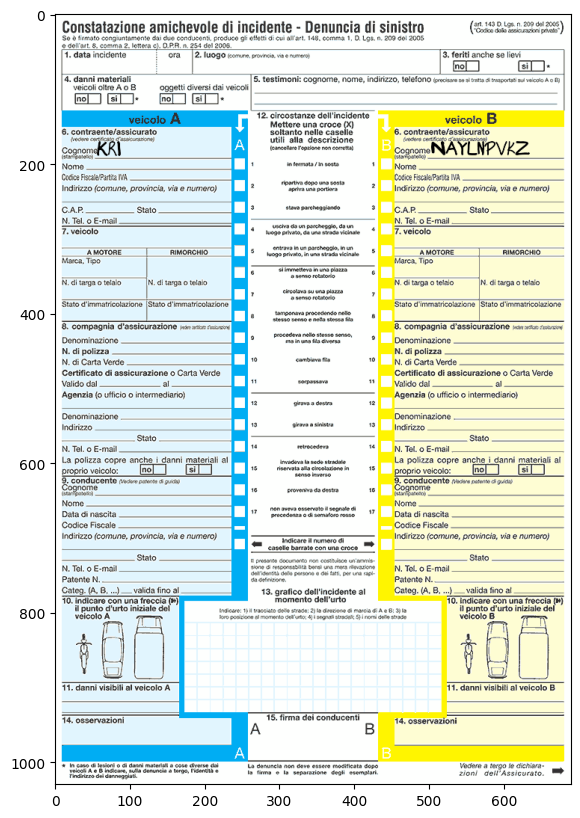

In [44]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [80]:
doc_height = sample_image.shape[0]
doc_width = sample_image.shape[1]

In [85]:
box_coords = []

for box in boxes:
    start_x, start_y, end_x, end_y = denormalise_box_coordinates(box["start_x_norm"], box["start_y_norm"], 
                                                                 box["end_x_norm"], box["end_y_norm"],
                                                                 doc_width=doc_width, doc_height=doc_height)

    box_coords.append([[start_x, start_y], [end_x, start_y], [end_x, end_y], [start_x, end_y]])

In [86]:
box_coords

[[[55, 170], [88, 170], [88, 190], [55, 190]],
 [[503, 170], [635, 170], [635, 189], [503, 189]]]

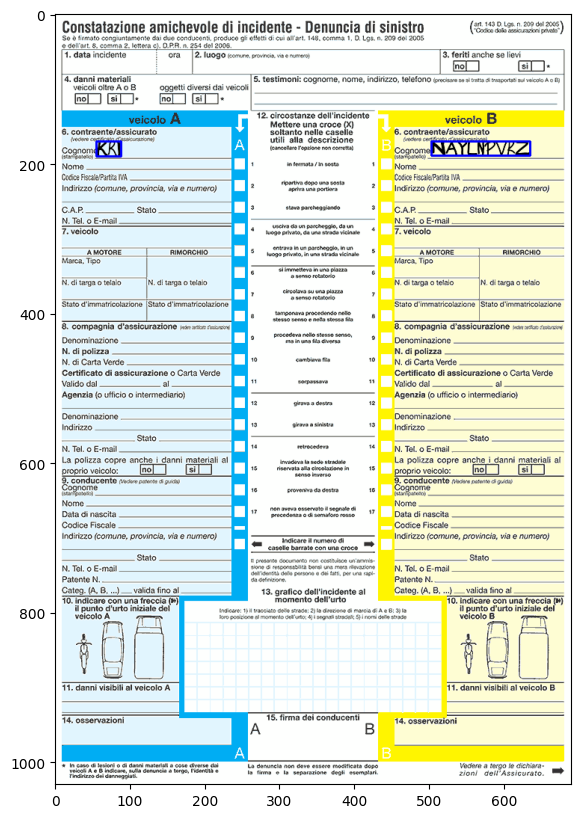

In [95]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(draw_ocr(sample_image, box_coords), cv2.COLOR_BGR2RGB))
plt.show()

### Apply Degradations

In [718]:
from sample_generation.degradation import *

#### gaussian blur

In [1066]:
image_gaussian_blur = gaussian_blur(sample_image, kernel_size=3)

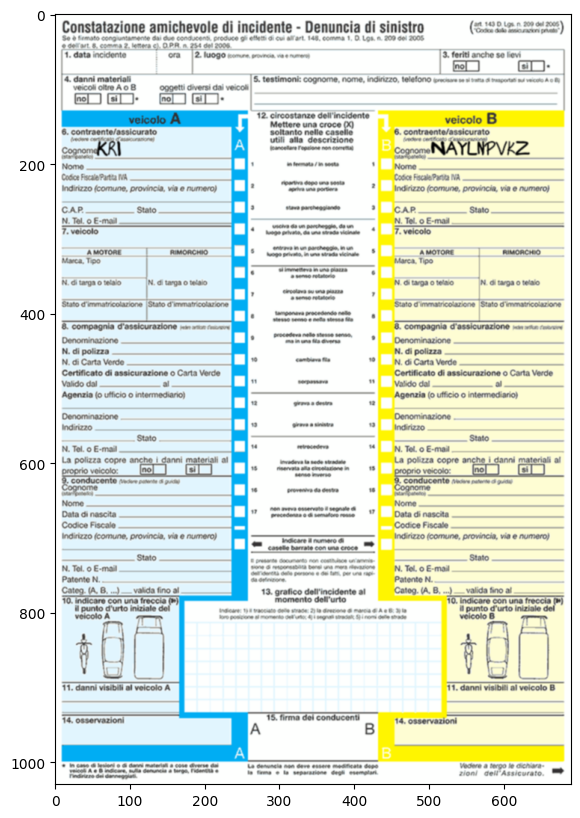

In [1067]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(image_gaussian_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### motion blur

In [341]:
image_motion_blur = motion_blur(sample_image, kernel_size=5)

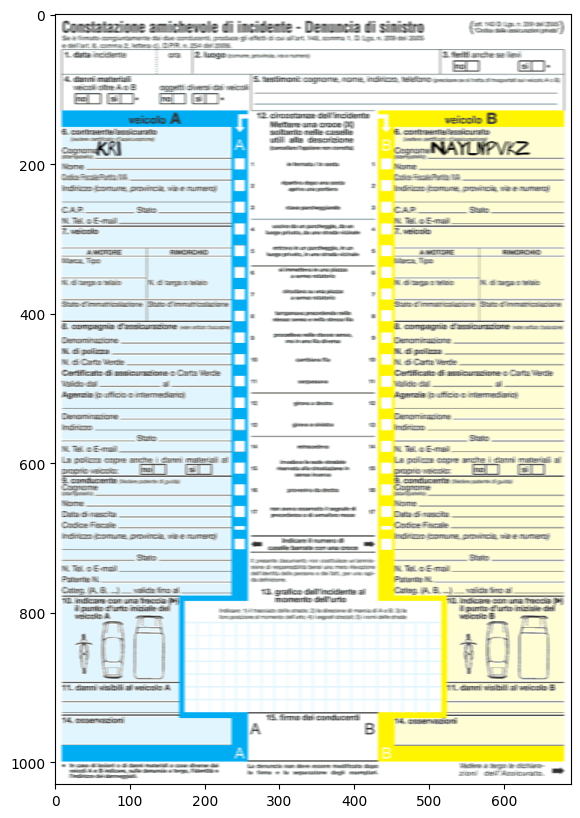

In [342]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(image_motion_blur, cv2.COLOR_BGR2RGB))
plt.show()

#### gaussian noise

In [1083]:
image_gaussian_noise = add_gaussian_noise(sample_image, mean=0, std=0.9)

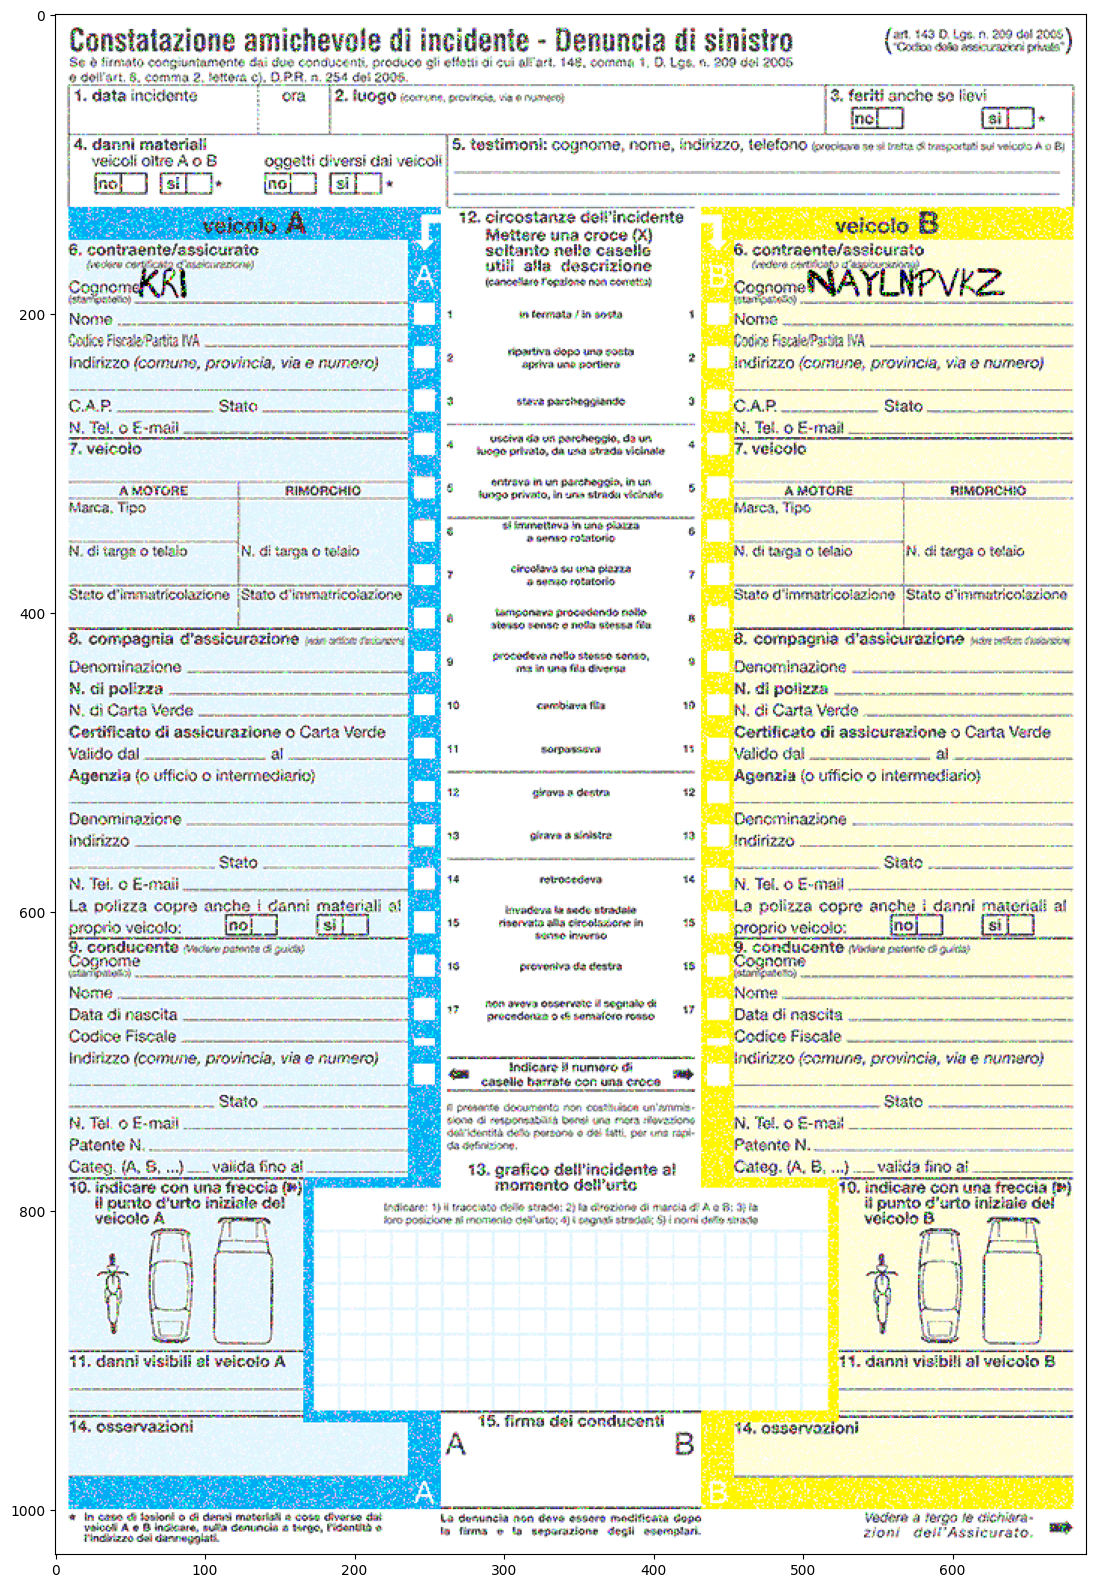

In [1084]:
plt.figure(figsize=(30, 20))
plt.imshow(cv2.cvtColor(image_gaussian_noise, cv2.COLOR_BGR2RGB))
plt.show()

#### salt and pepper noise

In [403]:
image_salt_pepper_noise = add_salt_and_pepper_noise(sample_image, prob=0.01)

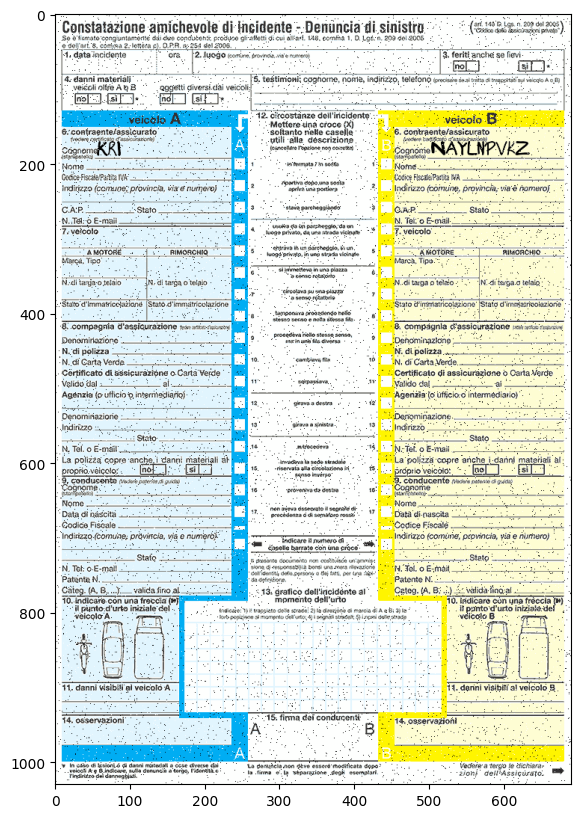

In [404]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(image_salt_pepper_noise, cv2.COLOR_BGR2RGB))
plt.show()

#### brightness and contrast

In [1095]:
new_image_brightness_contrast = change_brightness_and_contrast(sample_image, alpha=1, beta=0)

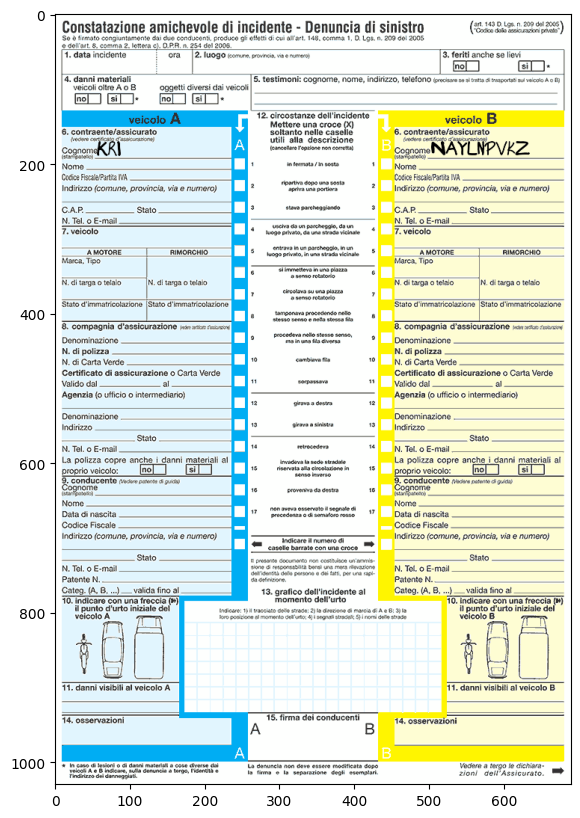

In [1096]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(new_image_brightness_contrast, cv2.COLOR_BGR2RGB))
plt.show()

#### distortion and warping

TODO recalculate box locations

In [209]:
distorted_image = distortion_and_warping(sample_image)

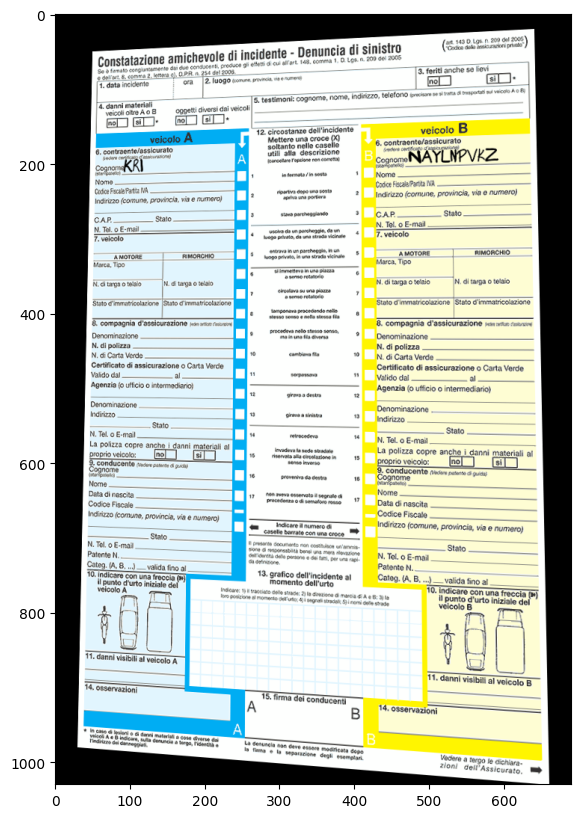

In [210]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(distorted_image, cv2.COLOR_BGR2RGB))
plt.show()

In [285]:
rows, cols, _ = sample_image.shape
src_points = np.float32([[100, 100], [110, 100], [100, 110], [110, 110]])
dst_points = np.float32([[50, 50], [60, 50], [50, 60], [60, 60]])

In [286]:
src_points

array([[100., 100.],
       [110., 100.],
       [100., 110.],
       [110., 110.]], dtype=float32)

In [287]:
dst_points

array([[50., 50.],
       [60., 50.],
       [50., 60.],
       [60., 60.]], dtype=float32)

In [288]:
matrix = cv2.getPerspectiveTransform(src_points, dst_points)

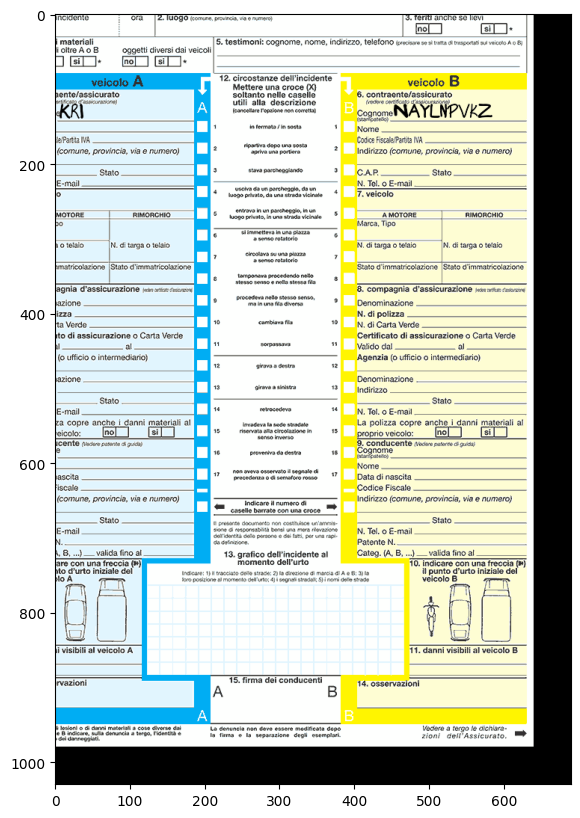

In [289]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(cv2.warpPerspective(sample_image, matrix, (cols, rows)), cv2.COLOR_BGR2RGB))
plt.show()

#### wave distortion

In [988]:
distorted_image, new_boxes = wave_distortion(sample_image, box_coords, amplitude=5, frequency=0.005)

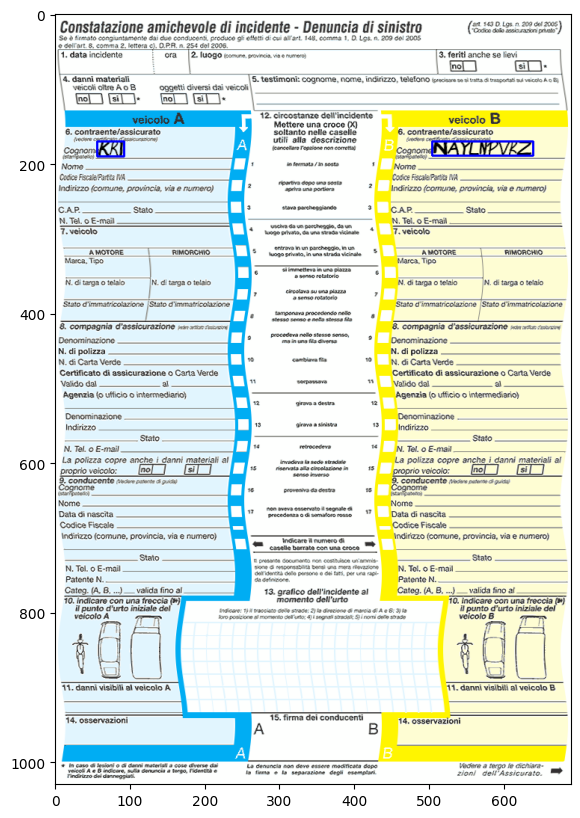

In [990]:
plt.figure(figsize=(20, 10))
plt.imshow(cv2.cvtColor(draw_ocr(distorted_image, new_boxes), cv2.COLOR_BGR2RGB))
plt.show()

### Apply Random Degradations

In [326]:
import random

In [1072]:
degradations = [{"function": gaussian_blur, "parameters": {"kernel_size": np.arange(1, 5, 2)}}, 
                {"function": motion_blur, "parameters": {"kernel_size": np.arange(1, 4, 1)}},
                {"function": gaussian_noise, "parameters": {}},
                {"function": salt_pepper_noise, "parameters": {"prob": np.arange(0.001, 0.01, 0.001)}},
                {"function": brightness_contrast, "parameters": {"alpha": np.arange(0.8, 1.2, 0.1), 
                                                                 "beta": np.arange(-20, 20, 5)}},
                {"function": wave_distortion, "parameters": {"amplitude": np.arange(1, 5, 1),
                                                             "frequency": np.arange(0.001, 0.009, 0.001)}},
                 ]

n = random.randint(0, len(degradations))

random_degradations = random.sample(degradations, n)

In [1073]:
n, random_degradations

(4,
 [{'function': <function sample_generation.degradation.gaussian_noise(image, mean=0, std=1)>,
   'parameters': {}},
  {'function': <function sample_generation.degradation.salt_pepper_noise(image, prob=0.01)>,
   'parameters': {'prob': array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009])}},
  {'function': <function sample_generation.degradation.brightness_contrast(image, alpha=1.2, beta=10)>,
   'parameters': {'alpha': array([0.8, 0.9, 1. , 1.1]),
    'beta': array([-20, -15, -10,  -5,   0,   5,  10,  15])}},
  {'function': <function sample_generation.degradation.gaussian_blur(image, kernel_size=1)>,
   'parameters': {'kernel_size': array([1, 3])}}])

In [1074]:
degradated_image = sample_image

for degradation in random_degradations:
    params = {k: random.choice(v) for k, v in degradation["parameters"].items()}
    print(degradation["function"].__name__)
    print(params)

    if degradation["function"].__name__ == "wave_distortion":
        degradated_image, box_coords = degradation["function"](degradated_image, **params, box_coords=box_coords)
    else:
        degradated_image = degradation["function"](degradated_image, **params)

gaussian_noise
{}
salt_pepper_noise
{'prob': 0.005}
brightness_contrast
{'alpha': 1.1, 'beta': -20}
gaussian_blur
{'kernel_size': 3}


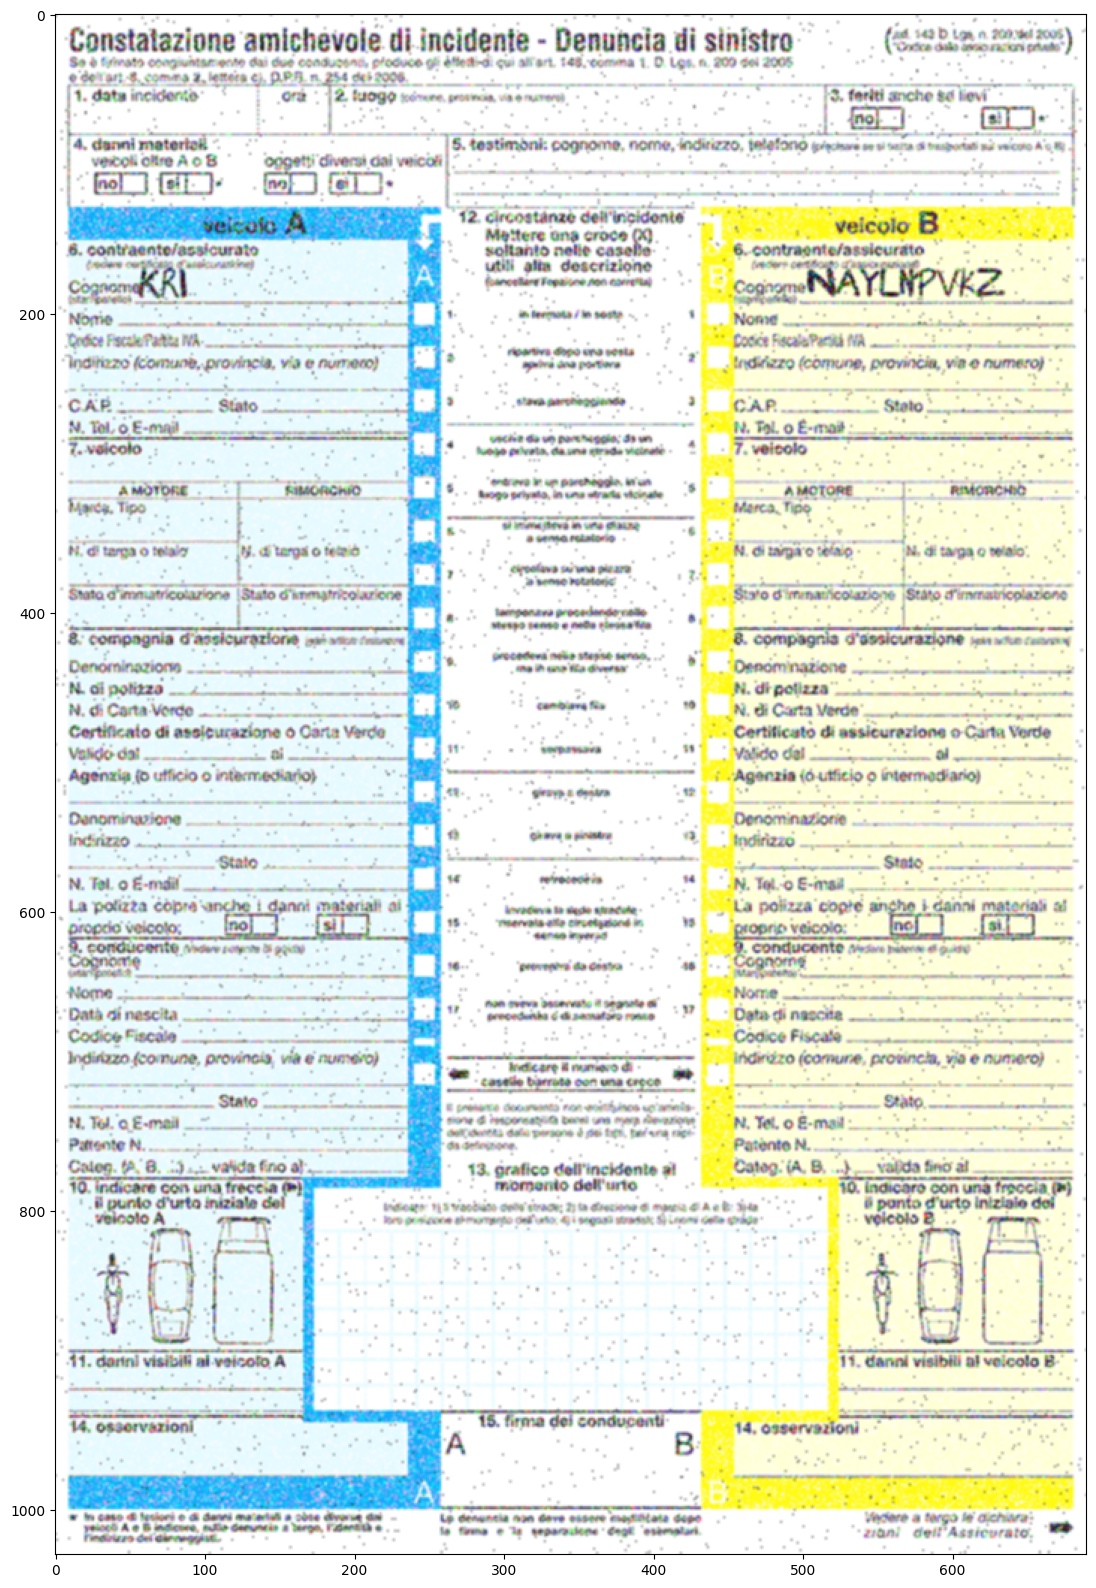

In [1076]:
plt.figure(figsize=(30, 20))
plt.imshow(cv2.cvtColor(degradated_image, cv2.COLOR_BGR2RGB))
plt.show()

### Degradation letters

In [1109]:
handwritten_dataset_processed_base_path = "../data/handwritten_dataset_processed"

In [1110]:
ls ../data/handwritten_dataset_processed/images/img025-045.png

../data/handwritten_dataset_processed/images/img025-045.png


In [1114]:
letter_image = cv2.imread(f"{handwritten_dataset_processed_base_path}/images/img025-045.png", flags=cv2.IMREAD_UNCHANGED)

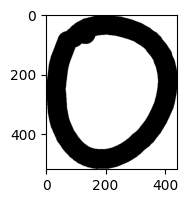

In [1129]:
plt.figure(figsize=(5, 2))
plt.imshow(cv2.cvtColor(letter_image, cv2.COLOR_BGRA2RGB))
plt.show()

In [1135]:
kernel = np.ones((10, 10), np.uint8) 

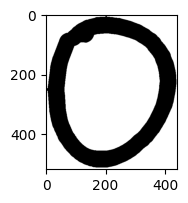

In [1139]:
plt.figure(figsize=(5, 2))
plt.imshow(cv2.cvtColor(cv2.dilate(letter_image, kernel=kernel, iterations=1), cv2.COLOR_BGRA2RGB))
plt.show()

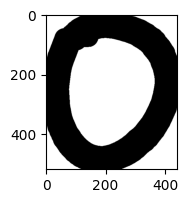

In [1132]:
plt.figure(figsize=(5, 2))
plt.imshow(cv2.cvtColor(cv2.erode(letter_image, kernel=kernel, iterations=5), cv2.COLOR_BGRA2RGB))
plt.show()

In [1144]:
random.choice()

array([], dtype=int64)

In [1145]:
np.linspace(1, 1, 10)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])